In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.backends.backend_pdf import PdfPages
from scipy import stats

import dpkt
import numpy as np
import time
import brewer2mpl

from AttackAnalysis import compute_effective_rate, compute_sending_rate
from analyze import compute_global_throughput, parse_file, removeOutliers
from read_conf import ReadHosts

In [3]:
host_to_ip, ip_to_host = ReadHosts('../experiment_conf/experiment_oak_new.conf')
interval = 5
root_dir = 'workdir/results-experiment5/'
figures_dir = 'paper-plots/exp_5_1_new/'

In [4]:
# sizes = ['size_1', 'size_2', 'size_3', 'size_4', 'size_5', 'size_6', 'size_7', 'size_8', 'size_9', 'size_10',
#         'size_11', 'size_12', 'size_13', 'size_14', 'size_15']
sizes = ['size_1', 'size_2', 'size_3', 'size_4', 'size_5', 'size_6', 'size_7', 'size_8', 'size_9', 'size_10',
         'size_11', 'size_12', 'size_13', 'size_14']
attacker_list = ['attacknode-1', 'attacknode-2', 'attacknode-3', 'attacknode-4', 'attacknode-5',
                'attacknode-6', 'attacknode-7', 'attacknode-8', 'attacknode-9', 'attacknode-10',
                'clientnode-11', 'clientnode-12', 'clientnode-13', 'clientnode-14', 'clientnode-15']

attacker_interval = 5

In [5]:
linestyles = ['-', '--', '-.', ':']
markers = []
for m in Line2D.markers:
    try:
        if len(m) == 1 and m != ' ':
            markers.append(m)
    except TypeError:
        pass

styles = markers + [
    r'$\lambda$',
    r'$\bowtie$',
    r'$\circlearrowleft$',
    r'$\clubsuit$',
    r'$\checkmark$']

In [6]:
def get_througput_array (entry, interval_s):
    num_buckets = np.size(entry.inbytes)
    buckets = np.arange(0, num_buckets * interval_s, interval_s)

    bps = 10e-6 * entry.inbytes * 8 / interval_s
    
    return buckets, bps

In [7]:
def compute_everything(prefix='results-exp5_1_', capfile='servernode-log_agent-tcpdump.cap',
                       verbose=False, postfix=[''], shost='servernode'):
    throughput = {}
    for post in postfix:
        filename = root_dir + prefix + post
        print "Generating throughput for %s" % filename
        filename += '/' + capfile

        start_time = time.time()
        throughput[post] = compute_global_throughput(filename, interval, host_to_ip[shost])
        end_time = time.time()
        if verbose:
            print "Time taken is ", end_time - start_time
            
    return throughput

In [8]:
def plot_throughput_overimpose(in_throughput, in_host_to_ip, postfix=[], 
                               host=['clientnode-1'], yincr=[5,50], ylimincr=[5,50], 
                               plt_title=['Client','Server'], ystart=[-1,-10]):
    
    fig = plt.figure()#figsize=(10,10))
    k = 1
    
    for host_entry in host:
        host_ip = in_host_to_ip[host_entry]
        ax = fig.add_subplot(1,2,k)
        
        plotnum = 0
        for post in postfix:
            maxbps = 0
            
            th = in_throughput[post]
            host_th = th[host_ip]

            host_bucket, host_bps = get_througput_array (host_th, interval_s=interval)
            
            ax.plot(host_bucket, host_bps, marker=None, markerfacecolor='none', 
                    label=post, linewidth=2, color=colors[plotnum])
            plotnum += 1
            
        maxbps = np.maximum(maxbps, np.max(host_bps))

        plt.title(plt_title[k-1])
        ax.grid(axis='y', color="0.9", linestyle='-', linewidth=1)
        ax.set_ylim(ystart[k-1], maxbps+ylimincr[k-1])
        ax.set_xticks([0,100,200,300,400,500,600])
        ax.set_xlim(0,599)

        # set y ticks
        yrange = np.arange (0,maxbps+ylimincr[k-1],yincr[k-1])
        ax.set_yticks(yrange)

        #if k%2==0:
        #    ax.set_yticklabels([])  
        if not k%2==0:
            ax.set_ylabel('Throughput (Mbps)')
        
        ax.set_xlabel('Time (seconds)')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.tick_params(axis='x', direction='out')
        ax.tick_params(axis='y', length=0)
        ax.set_axisbelow(True)

        ax.axvspan(120,480,color='red', alpha=0.1)
        k += 1
        

    if len(fig.axes)%2 == 0:
        ax = fig.axes[-2]
    else:
        ax = fig.axes[-1]
    
    legend = ax.legend(loc = 9, ncol=5, bbox_to_anchor=(1.05, -0.2), borderaxespad=1.0)
    frame = legend.get_frame()
    frame.set_facecolor('1')
    frame.set_edgecolor('0.75')
 
    #plt.savefig('paper-plots/throughput-exp2-2.pdf', bbox_inches = 'tight')
    #plt.show()

In [9]:
def plot_next_to_each_other(in_throughput, in_host_to_ip, postfix=[], host='clientnode-1',
                            yincr=5, ylimincr=5, ystart=-1, coloridx=1):
    fig = plt.figure()
    plotnum = 1
    
    num_subplots = len(postfix)
    if num_subplots == 0:
        print "[ERROR:] Empty input postfix array!"
        return 
    
    host_ip = in_host_to_ip[host]
    
    # put three plots next to each other
    num_rows = num_subplots / 3
    if num_subplots % 3 > 0:
        num_rows += 1
    
    k = 0
    for post in postfix:
        maxbps = 0
    
        ax = fig.add_subplot(num_rows,3,plotnum)
        th = in_throughput[post]
        host_th = th[host_ip]

        host_bucket, host_bps = get_througput_array (host_th, interval_s=interval)

        ax.plot(host_bucket, host_bps, marker=None, markerfacecolor='none', 
                label=post, linewidth=2, color=colors[coloridx])
        plotnum += 1
            
        maxbps = np.maximum(maxbps, np.max(host_bps))

        ax.grid(axis='y', color="0.9", linestyle='-', linewidth=1)
        ax.set_ylim(ystart, maxbps+ylimincr)
        ax.set_xticks([0,100,200,300,400,500,600])
        ax.set_xlim(0,599)

        # set y ticks
        yrange = np.arange (0,maxbps+ylimincr,yincr)
        ax.set_yticks(yrange)

#         if k%3==0:
#             ax.set_yticklabels([])  
        if k%3==0:
            ax.set_ylabel('Throughput (Mbps)')
        
        ax.set_xlabel('Time (seconds)')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.tick_params(axis='x', direction='out')
        ax.tick_params(axis='y', length=0)
        ax.set_axisbelow(True)
        
        # draw the average line
        ax.axhline(np.mean(host_bps), linestyle='--', linewidth=1)

        ax.axvspan(120,480,color='red', alpha=0.1)
        k += 1
        

#     if num_subplots%3 == 0:
#         ax = fig.axes[-3]
#     elif num_subplots%3 == 2:
#         ax = fig.axes[-2]
#     elif num_subplots%3 == 1:
#         ax = fig.axes[-1]
    
#     legend = ax.legend(loc = 9, ncol=5, bbox_to_anchor=(1.05, -0.2), borderaxespad=1.0)
#     frame = legend.get_frame()
#     frame.set_facecolor('1')
#     frame.set_edgecolor('0.75')

# Attack characteristics

### Cumulative attack rate is fixed at 5000 ppp

In [18]:
# change these for each section depending on your need
bmap = brewer2mpl.get_map('OrRd', 'Sequential', 4)
colors = bmap.mpl_colors

params = {
   'axes.labelsize': 9,
   'text.fontsize': 10,
   'legend.fontsize': 9,
   'legend.handlelength': 2,
   'xtick.labelsize': 8,
   'ytick.labelsize': 8,
   'text.usetex': False,
   'figure.figsize': [9, 14]
   }
plt.rcParams.update(params)

In [13]:
attack_rates = {}

size_itr = 1
for size in sizes:
    att_itr = 0
    attack_rates[size_itr] = {}
    while (att_itr < size_itr):
        attacker = attacker_list[att_itr]
        attack_file_template = attacker + '-attack_log-tcpdump.cap'
        attacker_ip = host_to_ip[attacker]
        
        cap_file = root_dir + 'results-exp5_1_' + size + '/' + attack_file_template
        print "-----> Using cap file: %s" % cap_file
        
        effective_rate = compute_effective_rate(cap_file, attacker_interval, False)    
        entry = effective_rate[attacker_ip]
        attack_rates[size_itr][attacker_ip] = entry
        att_itr += 1
    
    size_itr += 1

-----> Using cap file: workdir/results-experiment5/results-exp5_1_size_1/attacknode-1-attack_log-tcpdump.cap
[WARNING:] Packets in cap file are out of order.
+----------------------------------------------------+
Statistics for host 10.1.4.3
Total number of attempted connections: 	84980
Total number of acked connections:     	778
Total number of failed connections:    	82920
Total number of replies received:      	8921
Average ACK rate:                      	1.96962025316
+----------------------------------------------------+
-----> Using cap file: workdir/results-experiment5/results-exp5_1_size_2/attacknode-1-attack_log-tcpdump.cap
[WARNING:] Packets in cap file are out of order.
+----------------------------------------------------+
Statistics for host 10.1.4.3
Total number of attempted connections: 	64819
Total number of acked connections:     	297
Total number of failed connections:    	64405
Total number of replies received:      	5358
Average ACK rate:                      	0.9
+

[WARNING:] Packets in cap file are out of order.
+----------------------------------------------------+
Statistics for host 10.1.4.4
Total number of attempted connections: 	13857
Total number of acked connections:     	129
Total number of failed connections:    	13313
Total number of replies received:      	6251
Average ACK rate:                      	0.335064935065
+----------------------------------------------------+
-----> Using cap file: workdir/results-experiment5/results-exp5_1_size_6/attacknode-3-attack_log-tcpdump.cap
[WARNING:] Packets in cap file are out of order.
+----------------------------------------------------+
Statistics for host 10.1.4.5
Total number of attempted connections: 	25019
Total number of acked connections:     	233
Total number of failed connections:    	23401
Total number of replies received:      	7345
Average ACK rate:                      	0.561445783133
+----------------------------------------------------+
-----> Using cap file: workdir/results-expe

[WARNING:] Packets in cap file are out of order.
+----------------------------------------------------+
Statistics for host 10.1.4.7
Total number of attempted connections: 	17343
Total number of acked connections:     	109
Total number of failed connections:    	16758
Total number of replies received:      	6785
Average ACK rate:                      	0.330303030303
+----------------------------------------------------+
-----> Using cap file: workdir/results-experiment5/results-exp5_1_size_8/attacknode-6-attack_log-tcpdump.cap
[WARNING:] Packets in cap file are out of order.
+----------------------------------------------------+
Statistics for host 10.1.7.3
Total number of attempted connections: 	15275
Total number of acked connections:     	132
Total number of failed connections:    	15116
Total number of replies received:      	5107
Average ACK rate:                      	0.643902439024
+----------------------------------------------------+
-----> Using cap file: workdir/results-expe

[WARNING:] Packets in cap file are out of order.
+----------------------------------------------------+
Statistics for host 10.1.4.6
Total number of attempted connections: 	15929
Total number of acked connections:     	87
Total number of failed connections:    	14738
Total number of replies received:      	3288
Average ACK rate:                      	0.225974025974
+----------------------------------------------------+
-----> Using cap file: workdir/results-experiment5/results-exp5_1_size_10/attacknode-5-attack_log-tcpdump.cap
[WARNING:] Packets in cap file are out of order.
+----------------------------------------------------+
Statistics for host 10.1.4.7
Total number of attempted connections: 	8973
Total number of acked connections:     	51
Total number of failed connections:    	8910
Total number of replies received:      	4701
Average ACK rate:                      	0.147826086957
+----------------------------------------------------+
-----> Using cap file: workdir/results-experim

+----------------------------------------------------+
Statistics for host 10.1.7.7
Total number of attempted connections: 	12497
Total number of acked connections:     	251
Total number of failed connections:    	10800
Total number of replies received:      	3973
Average ACK rate:                      	0.697222222222
+----------------------------------------------------+
-----> Using cap file: workdir/results-experiment5/results-exp5_1_size_11/clientnode-11-attack_log-tcpdump.cap
[WARNING:] Packets in cap file are out of order.
+----------------------------------------------------+
Statistics for host 10.1.3.3
Total number of attempted connections: 	23199
Total number of acked connections:     	133
Total number of failed connections:    	22089
Total number of replies received:      	3188
Average ACK rate:                      	0.345454545455
+----------------------------------------------------+
-----> Using cap file: workdir/results-experiment5/results-exp5_1_size_12/attacknode-1-att

[WARNING:] Packets in cap file are out of order.
+----------------------------------------------------+
Statistics for host 10.1.4.4
Total number of attempted connections: 	7567
Total number of acked connections:     	58
Total number of failed connections:    	7490
Total number of replies received:      	4381
Average ACK rate:                      	0.158904109589
+----------------------------------------------------+
-----> Using cap file: workdir/results-experiment5/results-exp5_1_size_13/attacknode-3-attack_log-tcpdump.cap
[WARNING:] Packets in cap file are out of order.
+----------------------------------------------------+
Statistics for host 10.1.4.5
Total number of attempted connections: 	23218
Total number of acked connections:     	72
Total number of failed connections:    	21356
Total number of replies received:      	4310
Average ACK rate:                      	0.24
+----------------------------------------------------+
-----> Using cap file: workdir/results-experiment5/resul

[WARNING:] Packets in cap file are out of order.
+----------------------------------------------------+
Statistics for host 10.1.4.6
Total number of attempted connections: 	12156
Total number of acked connections:     	186
Total number of failed connections:    	11791
Total number of replies received:      	4230
Average ACK rate:                      	0.539130434783
+----------------------------------------------------+
-----> Using cap file: workdir/results-experiment5/results-exp5_1_size_14/attacknode-5-attack_log-tcpdump.cap
[WARNING:] Packets in cap file are out of order.
+----------------------------------------------------+
Statistics for host 10.1.4.7
Total number of attempted connections: 	7490
Total number of acked connections:     	35
Total number of failed connections:    	7414
Total number of replies received:      	4395
Average ACK rate:                      	0.109375
+----------------------------------------------------+
-----> Using cap file: workdir/results-experiment5/

In [14]:
sending_rates = {}

size_itr = 1
for size in sizes:
    att_itr = 0
    sending_rates[size_itr] = {}
    while (att_itr < size_itr):
        attacker = attacker_list[att_itr]
        attack_file_template = attacker + '-attack_log-tcpdump.cap'
        attacker_ip = host_to_ip[attacker]
        
        cap_file = root_dir + 'results-exp5_1_' + size + '/' + attack_file_template
        # cap_file = '/data/ddos-oakland/workdir/results-nping/results-nping-nodefense/' + attack_file_template
        print "-----> Using cap file: %s" % cap_file
        
        effective_rate = compute_sending_rate(cap_file, attacker_interval, attacker_ip, 0)    
        sending_rates[size_itr][attacker_ip] = effective_rate
        
        att_itr += 1
    size_itr += 1

-----> Using cap file: workdir/results-experiment5/results-exp5_1_size_1/attacknode-1-attack_log-tcpdump.cap
-----> Using cap file: workdir/results-experiment5/results-exp5_1_size_2/attacknode-1-attack_log-tcpdump.cap
-----> Using cap file: workdir/results-experiment5/results-exp5_1_size_2/attacknode-2-attack_log-tcpdump.cap
-----> Using cap file: workdir/results-experiment5/results-exp5_1_size_3/attacknode-1-attack_log-tcpdump.cap
-----> Using cap file: workdir/results-experiment5/results-exp5_1_size_3/attacknode-2-attack_log-tcpdump.cap
-----> Using cap file: workdir/results-experiment5/results-exp5_1_size_3/attacknode-3-attack_log-tcpdump.cap
-----> Using cap file: workdir/results-experiment5/results-exp5_1_size_4/attacknode-1-attack_log-tcpdump.cap
-----> Using cap file: workdir/results-experiment5/results-exp5_1_size_4/attacknode-2-attack_log-tcpdump.cap
-----> Using cap file: workdir/results-experiment5/results-exp5_1_size_4/attacknode-3-attack_log-tcpdump.cap
-----> Using cap fi

-----> Using cap file: workdir/results-experiment5/results-exp5_1_size_12/attacknode-10-attack_log-tcpdump.cap
-----> Using cap file: workdir/results-experiment5/results-exp5_1_size_12/clientnode-11-attack_log-tcpdump.cap
-----> Using cap file: workdir/results-experiment5/results-exp5_1_size_12/clientnode-12-attack_log-tcpdump.cap
-----> Using cap file: workdir/results-experiment5/results-exp5_1_size_13/attacknode-1-attack_log-tcpdump.cap
-----> Using cap file: workdir/results-experiment5/results-exp5_1_size_13/attacknode-2-attack_log-tcpdump.cap
-----> Using cap file: workdir/results-experiment5/results-exp5_1_size_13/attacknode-3-attack_log-tcpdump.cap
-----> Using cap file: workdir/results-experiment5/results-exp5_1_size_13/attacknode-4-attack_log-tcpdump.cap
-----> Using cap file: workdir/results-experiment5/results-exp5_1_size_13/attacknode-5-attack_log-tcpdump.cap
-----> Using cap file: workdir/results-experiment5/results-exp5_1_size_13/attacknode-6-attack_log-tcpdump.cap
-----> 

In [15]:
numerical_sizes = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]

full_rates = {}
full_ack_rates = {}
for size in numerical_sizes:
    flatten_rates = None
    ack_rates = None
    att_itr = 0
    while (att_itr < size):
        attacker = host_to_ip[attacker_list[att_itr]]
        local_rate = sending_rates[size][attacker]
        if (flatten_rates is None):
            flatten_rates = local_rate
        else:
            flen = len(flatten_rates)
            rlen = len(local_rate)
            
            padded_rate = local_rate
            if flen > rlen:
                padded_rate = np.pad(local_rate, (0, flen-rlen), 'constant')
            elif rlen > flen:
                flatten_rates =  np.pad(flatten_rates, (0, rlen-flen), 'constant')
            assert (len(flatten_rates) == len(padded_rate))
            flatten_rates = flatten_rates + padded_rate
        
        local_ack_rate = attack_rates[size][attacker]
        if (ack_rates is None):
            ack_rates = local_ack_rate
        else:
            flen = len(ack_rates)
            rlen = len(local_ack_rate)
            
            padded_ack_rate = local_ack_rate
            if flen > rlen:
                padded_ack_rate = np.pad(local_ack_rate, (0, flen-rlen), 'constant')
            elif rlen > flen:
                ack_rates = np.pad(ack_rates, (0,rlen-flen), 'constant')
            assert(len(ack_rates) == len(padded_ack_rate))
            ack_rates = ack_rates + padded_ack_rate
        att_itr += 1
            
    full_rates[size] = flatten_rates
    full_ack_rates[size] = ack_rates

# get the stuff for the sending rates
avg_rates = np.array([0]*len(numerical_sizes))
err_bars = np.array([0]*len(numerical_sizes))
i=0
for size in sizes:
    avg_rates[i] = np.mean(full_rates[i+1])
    err_bars[i] = stats.sem(full_rates[i+1])
    i += 1

# now do the same for the ack rates
avg_ack_rates = np.array([0]*len(numerical_sizes))
err_ack_bars = np.array([0]*len(numerical_sizes))
i=0
for size in sizes:
    avg_ack_rates[i] = np.mean(full_ack_rates[i+1])
    err_ack_bars[i] = stats.sem(full_ack_rates[i+1])
    i += 1

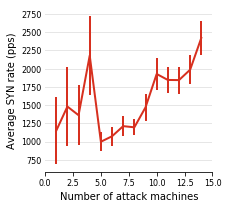

In [16]:
# change these for each section depending on your need
bmap = brewer2mpl.get_map('OrRd', 'Sequential', 4)
colors = bmap.mpl_colors

params = {
   'axes.labelsize': 10,
   'text.fontsize': 10,
   'legend.fontsize': 9,
   'legend.handlelength': 2,
   'xtick.labelsize': 8,
   'ytick.labelsize': 8,
   'text.usetex': False,
   'figure.figsize': [3,3]
   }
plt.rcParams.update(params)

figpath = figures_dir + 'syn_rate.pdf'

fig = plt.figure()
# now plot the stuff
ax = fig.add_subplot(1,1,1)
ax.errorbar(numerical_sizes,  avg_rates, yerr=err_bars, linewidth=2, color=colors[-1])
ax.set_xlabel('Number of attack machines')
ax.set_ylabel('Average SYN rate (pps)')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(axis='y', color="0.9", linestyle='-', linewidth=1)
#ax.set_xlim(50,1050)
ax.set_xlim(0,15)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.tick_params(axis='x', direction='out')
ax.tick_params(axis='y', length=0)

plt.savefig(figpath, bbox_inches = 'tight')

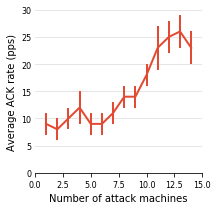

In [17]:
# change these for each section depending on your need
bmap = brewer2mpl.get_map('OrRd', 'Sequential', 3)
colors = bmap.mpl_colors

params = {
   'axes.labelsize': 10,
   'text.fontsize': 10,
   'legend.fontsize': 9,
   'legend.handlelength': 2,
   'xtick.labelsize': 8,
   'ytick.labelsize': 8,
   'text.usetex': False,
   'figure.figsize': [3,3]
   }
plt.rcParams.update(params)

fig = plt.figure()
figpath = figures_dir + 'ack_rate.pdf'

ax2 = fig.add_subplot(1,1,1)
ax2.errorbar(numerical_sizes, avg_ack_rates, yerr=err_ack_bars, linewidth=2, color=colors[-1])
ax2.set_xlabel('Number of attack machines')
ax2.set_ylabel('Average ACK rate (pps)')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.grid(axis='y', color="0.9", linestyle='-', linewidth=1)
ax2.set_xlim(0,15)
ax2.set_ylim(0,30)
ax2.get_xaxis().tick_bottom()
ax2.get_yaxis().tick_left()
ax2.tick_params(axis='x', direction='out')
ax2.tick_params(axis='y', length=0)

plt.savefig(figpath, bbox_inches = 'tight')

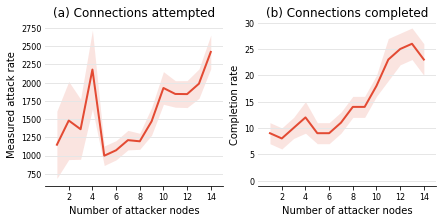

In [22]:
# change these for each section depending on your need
bmap = brewer2mpl.get_map('OrRd', 'Sequential', 3)
colors = bmap.mpl_colors

params = {
   'axes.labelsize': 10,
   'text.fontsize': 10,
   'legend.fontsize': 9,
   'legend.handlelength': 2,
   'xtick.labelsize': 8,
   'ytick.labelsize': 8,
   'text.usetex': False,
   'figure.figsize': [7,3]
   }
plt.rcParams.update(params)

figpath = figures_dir + 'combined.pdf'

fig = plt.figure()
# now plot the stuff
ax = fig.add_subplot(1,2,1)
ax.plot(numerical_sizes,  avg_rates, linewidth=2, color=colors[-1])
high=[]
low=[]
for val, err in zip(avg_rates, err_bars):
    high.append(val+err)
    low.append(val-err)

ax.fill_between(numerical_sizes, high, low, alpha=0.15, linewidth=0, color=colors[-1])

ax.set_xlabel('Number of attacker nodes')
ax.set_ylabel('Measured attack rate')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(axis='y', color="0.9", linestyle='-', linewidth=1)
#ax.set_xlim(50,1050)
ax.set_xlim(0,15)
ax.set_xticks([2,4,6,8,10,12,14])
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.tick_params(axis='x', direction='out')
ax.tick_params(axis='y', length=0)
ax.set_title('(a) Connections attempted')


ax2 = fig.add_subplot(1,2,2)

ax2.plot(numerical_sizes, avg_ack_rates, linewidth=2, color=colors[-1])
high=[]
low=[]
for val, err in zip(avg_ack_rates, err_ack_bars):
    high.append(val+err)
    low.append(val-err)

ax2.fill_between(numerical_sizes, high, low, alpha=0.15, linewidth=0, color=colors[-1])


ax2.set_xlabel('Number of attacker nodes')
ax2.set_ylabel('Completion rate')

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.grid(axis='y', color="0.9", linestyle='-', linewidth=1)
ax2.set_xlim(0,15)
ax2.set_xticks([2,4,6,8,10,12,14])
ax2.set_ylim(-1,30)
ax2.get_xaxis().tick_bottom()
ax2.get_yaxis().tick_left()
ax2.tick_params(axis='x', direction='out')
ax2.tick_params(axis='y', length=0)
ax2.set_title('(b) Connections completed')

plt.savefig(figpath, bbox_inches = 'tight')

# Check on the clients throughput

In [16]:
# change these for each section depending on your need
bmap = brewer2mpl.get_map('OrRd', 'Sequential', 3)
colors = bmap.mpl_colors

params = {
   'axes.labelsize': 9,
   'text.fontsize': 10,
   'legend.fontsize': 9,
   'legend.handlelength': 2,
   'xtick.labelsize': 8,
   'ytick.labelsize': 8,
   'text.usetex': False,
   'figure.figsize': [9, 14]
   }
plt.rcParams.update(params)

In [21]:
throughput_nodefense = compute_everything(verbose=True, postfix=['size1', 'size2', 'size3', 'size4', 'size5', 
                                                                 'size6', 'size7', 'size8', 'size9', 'size10'])

Generating throughput for workdir/results-experiment5/results-exp5_1_size1
Time to read pcap file 0.0268149375916
Time taken is  48.6122479439
Generating throughput for workdir/results-experiment5/results-exp5_1_size2
Time to read pcap file 0.000226020812988
Time taken is  47.7774541378
Generating throughput for workdir/results-experiment5/results-exp5_1_size3
Time to read pcap file 0.000195026397705
Time taken is  47.9280459881
Generating throughput for workdir/results-experiment5/results-exp5_1_size4
Time to read pcap file 0.000212907791138
Time taken is  43.3476099968
Generating throughput for workdir/results-experiment5/results-exp5_1_size5
Time to read pcap file 0.000199794769287
Time taken is  47.3792760372
Generating throughput for workdir/results-experiment5/results-exp5_1_size6
Time to read pcap file 0.00021505355835
Time taken is  47.4986848831
Generating throughput for workdir/results-experiment5/results-exp5_1_size7
Time to read pcap file 0.000216007232666
Time taken is  45

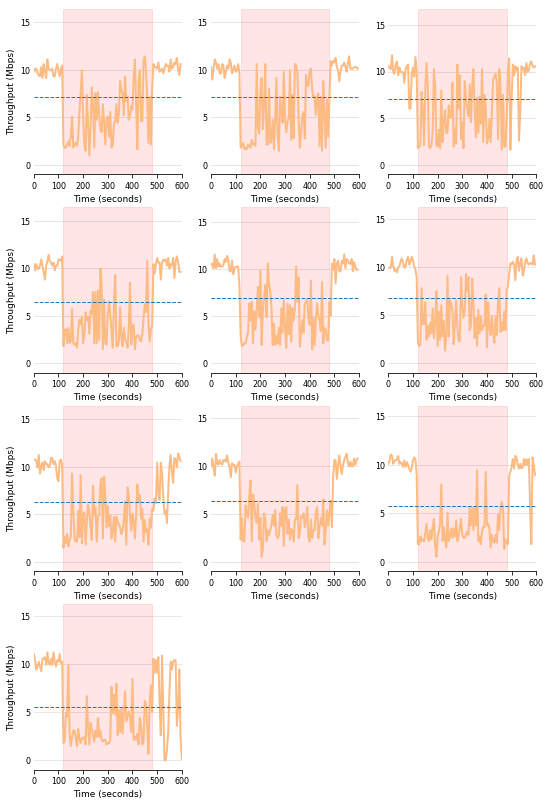

In [28]:
throughput = throughput_nodefense

plot_next_to_each_other(throughput, host_to_ip, postfix=sizes)

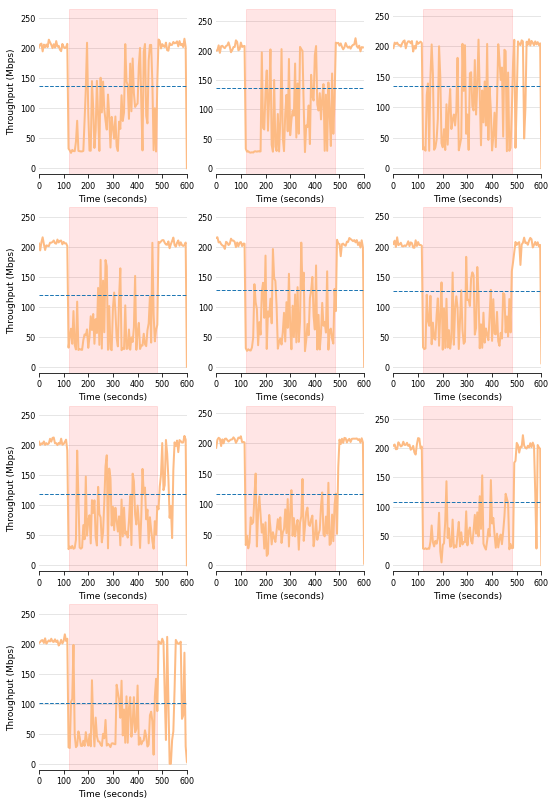

In [29]:
plot_next_to_each_other(throughput, host_to_ip, postfix=sizes, host='servernode', 
                        ylimincr=50, yincr=50, ystart=-10)

# Check on the attacker's rate

In [33]:
attacker = 'attacknode-1'
attack_file_template = attacker + '-attack_log-tcpdump.cap'
attacker_ip = host_to_ip[attacker]

cap_file = root_dir + 'results-exp5_1_size1/' + attack_file_template

attacker_interval = 5

In [34]:
effective_rate = compute_effective_rate(cap_file, attacker_interval, False)

[WARNING:] Packets in cap file are out of order.
+----------------------------------------------------+
Statistics for host 10.1.4.3
Total number of attempted connections: 	17296
Total number of acked connections:     	441
Total number of failed connections:    	15950
Total number of replies received:      	9073
Average ACK rate:                      	1.0756097561
+----------------------------------------------------+


<Container object of 82 artists>

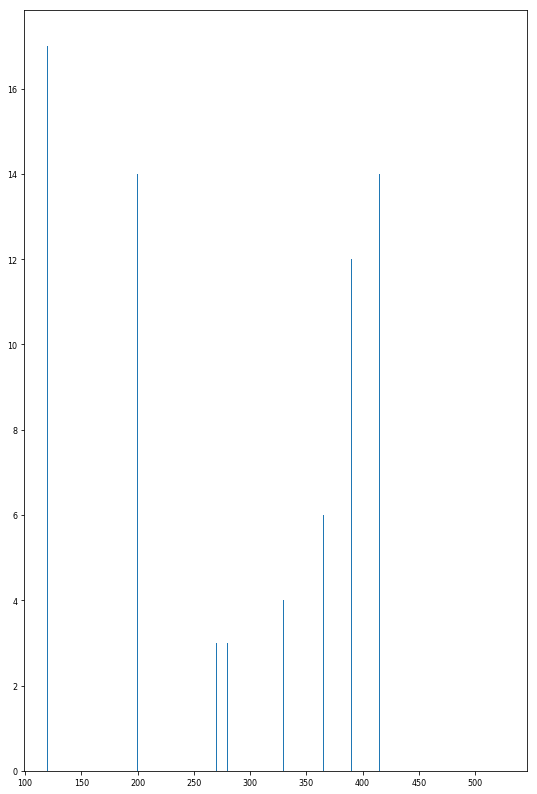

In [35]:
entry = effective_rate[attacker_ip]

num_buckets = np.size(entry)
buckets = np.arange(120, 120+num_buckets * attacker_interval, attacker_interval)
pps = entry/attacker_interval

plt.bar(buckets, pps)

In [37]:
sending_rates = compute_sending_rate(cap_file, attacker_interval, 1)

In [38]:
entry = sending_rates[attacker_ip]

num_buckets = np.size(entry)
buckets = np.arange(120, 120+num_buckets * attacker_interval, attacker_interval)
sps = entry/attacker_interval

plt.bar(buckets, sps)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

# Comparing sending rate and ack rate

It is basically showing that the nping is doing things in bursts, and that's way we cannot see a uniform sending rate acrss all of the applications.

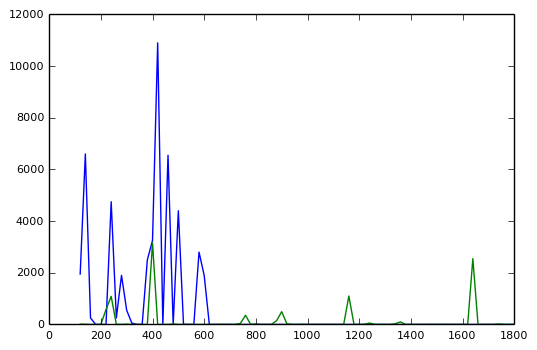

In [73]:
ack_rate = effective_rate[attacker_ip]
syn_rate = sending_rates[attacker_ip]

ack_num_buckets = np.size(ack_rate)
syn_num_buckets = np.size(syn_rate)

num_buckets = np.maximum(ack_num_buckets, syn_num_buckets)
buckets = np.arange(120, 120+num_buckets * attacker_interval, attacker_interval)

if ack_num_buckets < syn_num_buckets:
    ack_rate = np.append(ack_rate, [0]*(syn_num_buckets - ack_num_buckets))
elif syn_num_buckets < ack_num_buckets:
    syn_rate = np.append(syn_rate, [0]*(ack_num_buckets - syn_num_buckets))

plt.plot(buckets, 1000* ack_rate / attacker_interval)
plt.plot(buckets, syn_rate / attacker_interval)